# Inleveropdracht 4: Machine Translation & Document Search
#### Naam: Lucas van der Horst
#### Studentnummer: 1757028

## Deel I: Machine Translataion

In het eerste deel van deze opdracht ga je je eigen simpele (naïeve) machine translation systeem implementeren.

Het doel is:
Schrijf een programma dat Engelse naar Franse woorden vertaalt d.m.v. vector embeddings.
Implementeer vertaling als vinden van een matrix 
 die de volgende functie minimaliseert: 

Je krijgt:
- en_embeddings.p: Een subset Engelse woorden met hun vector embeddings
- fr_embeddings.p: Een subset Franse woorden met hun vector embeddings
- en_fr.train.txt: Een tekstbestand met Engelse woorden en hun Franse vertaling, te gebruiken om mee te trainen
- en_fr.test.txt: Een tekstbestand met andere Engelse woorden en hun Franse vertaling, te gebruiken om mee te testen

Waar maak je gebruik van:
- Vector Space Models (eerder behandeld)
- De Frobenius norm, de wortel van de som van de kwadraten van alle elementen van een matrix.
- Gradient Descent (eerder behandeld) op de genoemde gradient van de Frobenius norm
    - Probeer het met `400` trainingsstappen en een learning rate van `0.8`; je kun ook zelf experimenteren met deze waardes, maar het volledig trainen van deze dataset kan minuten duren afhandeling van je computer, dus we geven je vast waardes die in elk geval goed zouden moeten werken.
Om te vinden welk doelwoord het dichtste bij de output van je getrainde matrix R ligt, voor een nieuw bronwoord:
- k-Nearest Neighbors (eerder behandeld)
- Cosine Similarity (eerder behandeld)
Bereken de accuracy van jouw implementatie. Met bovenstaande instellingen kun je met deze bestanden al boven de 55% correcte vertalingen uitkomen.

En dat alleen met wat algebra!

Allereerst importeren we de benodigde libraries

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

Dan laden we de data in, en doen we alvast wat data transformaties om de data in een bruikbare vorm te krijgen.  

In [2]:
# Load the English and French embeddings
en_embeddings_dict = pickle.load(open('en_embeddings.p', 'rb'))
fr_embeddings_dict = pickle.load(open('fr_embeddings.p', 'rb'))
# Split the French embeddings into an embeddings matrix and a list of words
fr_embeddings_matrix = np.array(list(fr_embeddings_dict.values()))
fr_words = list(fr_embeddings_dict.keys())
# Load the translation pairs, this exists of a training and test set
en_fr_train = [line.split(' ') for line in open('en-fr.train.txt', 'r').read().splitlines()]
en_fr_test = [line.split(' ') for line in open('en-fr.test.txt', 'r').read().splitlines()]

In [3]:
# Filter the translations where both words are in the embeddings dictionaries
en_fr_train = [[en_word, fr_word] for en_word, fr_word in en_fr_train if en_word in en_embeddings_dict and fr_word in fr_embeddings_dict]
en_fr_test = [[en_word, fr_word] for en_word, fr_word in en_fr_test if en_word in en_embeddings_dict and fr_word in fr_embeddings_dict]

# Create the training and test arrays
X_train = np.array([en_embeddings_dict[en_word] for en_word, fr_word in en_fr_train])
Y_train = np.array([fr_embeddings_dict[fr_word] for en_word, fr_word in en_fr_train])

We optimaliseren matrix R door gradient descent toe te passen op de genoemde gradient van de Frobenius norm.

Loss at step 0: 0.013225615894086521
Loss at step 1: 0.011763798307839603
Loss at step 2: 0.011466716242608038
Loss at step 3: 0.011265761656231452
Loss at step 4: 0.011109471674107222
Loss at step 5: 0.0109824936704853
Loss at step 6: 0.010877016935157779
Loss at step 7: 0.010787974878633646
Loss at step 8: 0.010711807204015893
Loss at step 9: 0.010645925870102388
Loss at step 10: 0.010588405088571097
Loss at step 11: 0.010537782221241056
Loss at step 12: 0.010492925290159489
Loss at step 13: 0.01045294299883091
Loss at step 14: 0.01041712253184816
Loss at step 15: 0.010384885799451763
Loss at step 16: 0.010355758116857246
Loss at step 17: 0.01032934539765204
Loss at step 18: 0.010305317269823476
Loss at step 19: 0.01028339437785198
Loss at step 20: 0.010263338690384852
Loss at step 21: 0.010244945999294186
Loss at step 22: 0.010228040040200231
Loss at step 23: 0.010212467829774995
Loss at step 24: 0.010198095928306459
Loss at step 25: 0.010184807414629614
Loss at step 26: 0.010172499

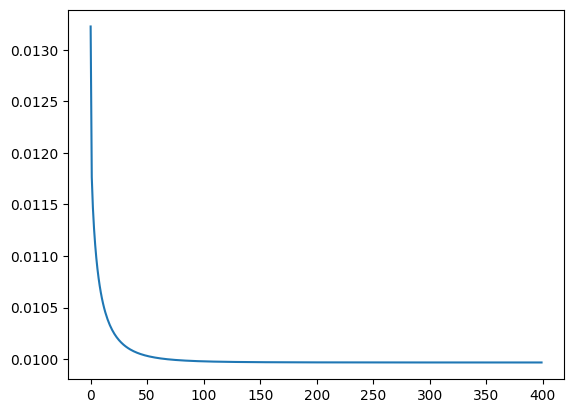

In [4]:
# Define the hyperparameters / constants
learning_rate = 0.8
EN_EMBEDDING_SIZE = tuple(en_embeddings_dict.values())[0].size
FR_EMBEDDING_SIZE = tuple(fr_embeddings_dict.values())[0].size
m = X_train.shape[0]

# Create the EN to FR matrix
R = np.zeros((EN_EMBEDDING_SIZE, FR_EMBEDDING_SIZE))

# Keep track of the loss
losses = []

# Do gradient descent
for step in range(400):
    # Forward the whole dataset
    predicted = np.dot(X_train, R)
    # Loss is the frobenius norm of the difference between the predicted and the real Y divided by the number of samples
    loss = np.linalg.norm(predicted - Y_train) / m
    # But now we calculate the gradient of the loss with respect to R
    gradient = np.dot(X_train.T, predicted - Y_train) * 2 / m
    # Take a step in the direction of the gradient
    R -= learning_rate * gradient
    # Keep track of the loss for inspection
    print(f'Loss at step {step}: {loss}')
    losses.append(loss)

# Plot the loss over time
plt.plot(losses)
plt.show()

We maken een functie die het dichste woord in de Franse vector space vindt bij een gegeven Engels woord door het engelse woord te vermenigvuldigen met de matrix R en vervolgens de cosine similarity te berekenen tussen de output vector en alle Franse woorden.

In [5]:
def get_closest_french_words(english_word, topn=1):
    """
    Search for the closest words in the FR dictionary with exhaustive search.
    
    :param english_word: The english word to translate
    :param topn: The number of closest words to return
    :return: A list of tuples with the closest words and their cosine similarity value
    """
    # Get the embedding of the english word
    en_embedding = en_embeddings_dict[english_word]
    # Predict the embedding of the french word by multiplying with R
    predicted_fr_embedding = np.dot(en_embedding, R)
    # Calculate the cosine similarity between the predicted embedding and all the french embeddings
    cosine_similarities = np.dot(fr_embeddings_matrix, predicted_fr_embedding)
    # Sort the most similar embeddings and return the topn
    most_similar_idx = cosine_similarities.argsort()[-topn:][::-1]
    # Return the topn most similar words with their cosine similarity value
    return [(fr_words[idx], cosine_similarities[idx]) for idx in most_similar_idx]

get_closest_french_words('house', topn=5)

[('appartement', 0.40534957554845513),
 ('maison', 0.36419687155694525),
 ('maisons', 0.35501995628263827),
 ('résidence', 0.3363790588094915),
 ('hôtel', 0.3138454414071172)]

Als laatst berekenen we de accuracy van onze implementatie door de vertaling van de woorden in de test set te vergelijken met de vertaling die onze implementatie geeft.  
Hieraan zien we dat onze implementatie een accuracy van 43% heeft.  
Dit is best hoog voor zo'n simpele implementatie.

In [6]:
# Calculate the accuracy on the test set
correct = 0
for en_word, fr_word in en_fr_test:
    if fr_word in [word for word, similarity in get_closest_french_words(en_word, 1)]:
        correct += 1
accuracy = correct / len(en_fr_test)
print(f"Accuracy on test set: {accuracy}")

Accuracy on test set: 0.43190661478599224


## Deel II: Document Search

Het tweede deel van deze opdracht ga je met behulp van word embeddings hele documenten met elkaar vergelijken: op basis van een tekst, kun je andere teksten vinden die er het meeste op lijken.

Het doel is:
Schrijf een programma dat gegeven een tekst, de n tweets uit de Twitter dataset vindt die er het meeste op lijken.
Gebruik KNN op één bucket van een LSH table zodat je niet alle documenten hoeft te doorzoeken. Door de randomness in LSH kun je daardoor wat goede matches missen, daarom noemen we dit Approximate KNN.

Waar maak je gebruik van:

- Optellen van word vectors van een document (nieuw): je krijgt zo een enkele vector die het hele document representeert
- Locality Sensitive Hashing (eerder behandeld)
- k-Nearest Neighbors (eerder behandeld)

We beginnen door de twitter dataset in te laden met nltk.

In [7]:
import nltk

nltk.download('twitter_samples')
tweets = nltk.corpus.twitter_samples.strings()
tweets

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/horstl/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


['hopeless for tmr :(',
 "Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(",
 '@Hegelbon That heart sliding into the waste basket. :(',
 '“@ketchBurning: I hate Japanese call him "bani" :( :(”\n\nMe too',
 'Dang starting next week I have "work" :(',
 "oh god, my babies' faces :( https://t.co/9fcwGvaki0",
 '@RileyMcDonough make me smile :((',
 '@f0ggstar @stuartthull work neighbour on motors. Asked why and he said hates the updates on search :( http://t.co/XvmTUikWln',
 'why?:("@tahuodyy: sialan:( https://t.co/Hv1i0xcrL2"',
 'Athabasca glacier was there in #1948 :-( #athabasca #glacier #jasper #jaspernationalpark #alberta #explorealberta #… http://t.co/dZZdqmf7Cz',
 "I have a really good m&amp;g idea but I'm never going to meet them :(((",
 '@Rampageinthebox mare ivan :(',
 '@SophiaMascardo happy trip, keep safe. see you soon :* :(',
 "I'm so tired hahahah :(",
 '@GrumpyCockney With knee replacements they get you up &amp; about the same day. :-(   Ou

We zetten alle tweets om in embeddings.  
We gebruiken dezelfde embeddings dictionary als in deel I.  
Om van woord embeddings naar document embeddings te gaan gebruiken we de gemiddelde embedding van alle woorden in het document (tweet).

In [8]:
def embed_tweet(tweet):
    """
    Embed an english tweet by averaging the embeddings of the words in the tweet.

    :param tweet: The tweet to embed
    :return: The embedding of the tweet, or None if no words in the tweet are in the embeddings dictionary
    """
    # Split the tweet into words and lowercase them
    words = tweet.lower().split(' ')
    # Get the embeddings of each word
    embeddings = [en_embeddings_dict[word] for word in words if word in en_embeddings_dict]
    # If there are no words in the embeddings dictionary, return None
    if len(embeddings) > 0:
        # Otherwise, return the average embedding of the words in the tweet
        return np.mean(embeddings, axis=0)

tweets_filtered = []
tweets_embeddings_filtered = []
for tweet in tweets:
    embedding = embed_tweet(tweet)
    if embedding is not None:
        tweets_filtered.append(tweet)
        tweets_embeddings_filtered.append(embedding)
tweets_embeddings_filtered = np.array(tweets_embeddings_filtered)
tweets_embeddings_filtered.shape

(28672, 300)

We maken een functie die de projection vectors voor de Locality Sensitive Hashing maakt, en meteen de embeddings aan de hand van deze projection vectors in buckets stopt.

In [9]:
def construct_projections_and_buckets(embeddings, num_projections=8):
    projection_vectors = np.random.randn(num_projections, EN_EMBEDDING_SIZE)
    binary_projections = np.dot(embeddings, projection_vectors.T) > 0
    buckets = {}
    for i, binary_hash in enumerate(binary_projections):
        buckets.setdefault(tuple(binary_hash), []).append(i)
    return projection_vectors, buckets

projection_vectors, buckets = construct_projections_and_buckets(tweets_embeddings_filtered)

We make a function that finds the k nearest neighbors of a given document by finding the bucket of the document, and then finding the k nearest neighbors in that bucket.

In [10]:
def get_nearest_tweets_singular(string, projection_vectors, buckets, topn=5):
    embedding = embed_tweet(string)
    binary_projection = np.dot(embedding, projection_vectors.T) > 0
    if tuple(binary_projection) not in buckets:
        return []
    bucket = buckets[tuple(binary_projection)]
    distances = [np.linalg.norm(embedding - tweets_embeddings_filtered[idx]) for idx in bucket]
    nearest_ids = np.argsort(distances)[:topn]
    return [tweets_filtered[bucket[nearest_id]] for nearest_id in nearest_ids]

get_nearest_tweets_singular('I love cats', projection_vectors, buckets)

['I Like Coca Cola , I Love Fanta , I dream about Pepsi and Die for Sprite they alls very sweeeeeeeety ♡♥♡♥ :-) ;-) :-D http://t.co/gUUlxAs9En',
 'Hamann is a Tory and has the cheek to lecture people on respect. Love it.',
 "Ar man, people talking about ukip as if they're areet. Some stupid, like scary stupid people knocking about. They're going to breed aswell.",
 '@makalamerry @LijGilmour but it wont be fun if im sick :((',
 '#isitok to think that ed miliband looks like the first prick that you want to see die a messy death in a horror movie.']

Now we have done this once, but for stable results we should do this multiple times with random projections and combine all the selected documents. And search that,  
For lack of a better word, I called this the "forest technique" in the code below.

In [11]:
def construct_projection_forest_and_buckets(embeddings, num_projections=8, num_trees=5):
    projection_forest = []
    buckets = []
    for i in range(num_trees):
        projection_vectors, bucket = construct_projections_and_buckets(embeddings, num_projections)
        projection_forest.append(projection_vectors)
        buckets.append(bucket)
    return projection_forest, buckets

def get_nearest_tweets_forest(string, projection_forest, buckets, topn=5):
    embedding = embed_tweet(string)
    cummalative_nearest_tweets = []
    for projection_vectors, bucket in zip(projection_forest, buckets):
        binary_projection = np.dot(embedding, projection_vectors.T) > 0
        if tuple(binary_projection) not in bucket:
            continue
        cummalative_nearest_tweets += bucket[tuple(binary_projection)]
    distances = [np.linalg.norm(embedding - tweets_embeddings_filtered[idx]) for idx in cummalative_nearest_tweets]
    nearest_ids = np.argsort(distances)[:topn]
    return [tweets_filtered[cummalative_nearest_tweets[nearest_id]] for nearest_id in nearest_ids]

projection_forest, buckets = construct_projection_forest_and_buckets(tweets_embeddings_filtered)
get_nearest_tweets_forest('Happy birthday', projection_forest, buckets)

['@Dinnerbone *Future MegaMoh in 7/29/2015* Happy Birthday to me :)',
 '@Little_Nells happy birthday :)🎉🎈',
 '@graphure Happy birthday buddy! :D',
 '@Stacyyy24 Happy Birthday :)',
 '@S0N0S_ Happy Birthday :)']